In [1]:
import librosa
from librosa import display
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
import os

%matplotlib inline 

In [ ]:
from importlib import reload

In [3]:
k = 1
fk = 1
resample_factor = 6
keys = 12
bins_per_octave = keys*k
sr = 44100
sr_resampled = sr*resample_factor
n_octaves = 9
n_bins = n_octaves*keys*k
hop_length = 256
file = "Lune.mp3"

In [4]:
if not os.path.exists('D.npy'):
    y, sr = librosa.load(file, sr=None, offset=0, duration=120)
    y_resampled = librosa.resample(y, sr, sr_resampled)
    D = np.abs(librosa.stft(y_resampled, hop_length=hop_length, n_fft=2048))
    C = np.abs(librosa.cqt(y_resampled, sr=sr_resampled, bins_per_octave=bins_per_octave, 
                           n_bins=n_bins, hop_length=hop_length, filter_scale=1/fk))

In [5]:
print("STFT shape: {} \nCQT shape: {}".format(D.shape, C.shape))
print("Sample rate: {} \nNew sample rate: {}".format(sr, sr_resampled))
print("N octaves: {}\nHop length: {} \nBins per octave: {} \nN bins: {}".format(n_octaves, hop_length,
                                                                                  bins_per_octave, n_bins))

STFT shape: (1025, 124032) 
CQT shape: (108, 124032)
Sample rate: 44100 
New sample rate: 264600
N octaves: 9
Hop length: 256 
Bins per octave: 12 
N bins: 108


In [6]:
if not os.path.exists('D.npy'):
    y_test, sr_test = librosa.load(file, sr=None, offset=120, duration=30)
    y_test_resampled = librosa.resample(y_test, sr, sr_resampled)
    D_test = np.abs(librosa.stft(y_test_resampled, hop_length=hop_length, n_fft=2048))
    C_test = np.abs(librosa.cqt(y_test_resampled, sr=sr_resampled, bins_per_octave=bins_per_octave, 
                                n_bins=n_bins, hop_length=hop_length, filter_scale=1/fk))

In [7]:
print("STFT shape: {} \nCQT shape: {}".format(D_test.shape, C_test.shape))

STFT shape: (1025, 31008) 
CQT shape: (108, 31008)


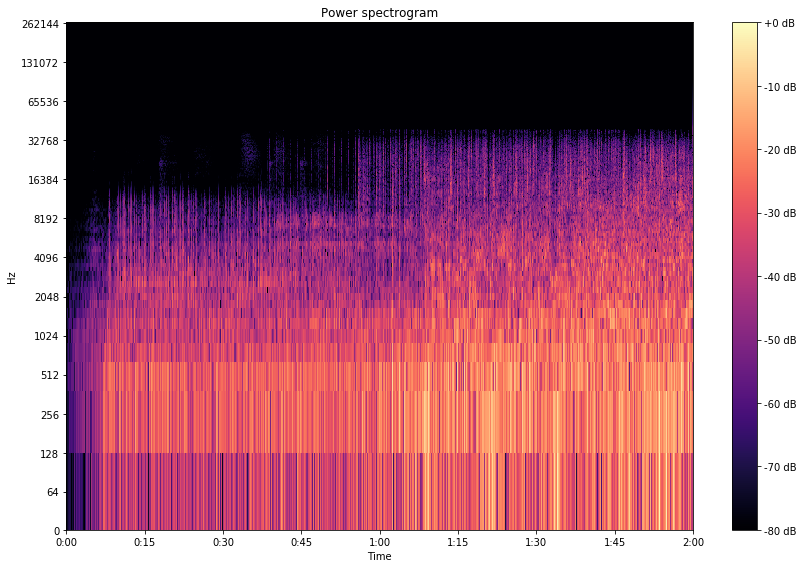

In [8]:
if not os.path.exists('D.npy'):
    plt.figure(figsize=(12, 8))
    display.specshow(librosa.amplitude_to_db(D, ref=np.max), sr=sr_resampled*2, y_axis='log', x_axis='time')
    plt.title('Power spectrogram')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()

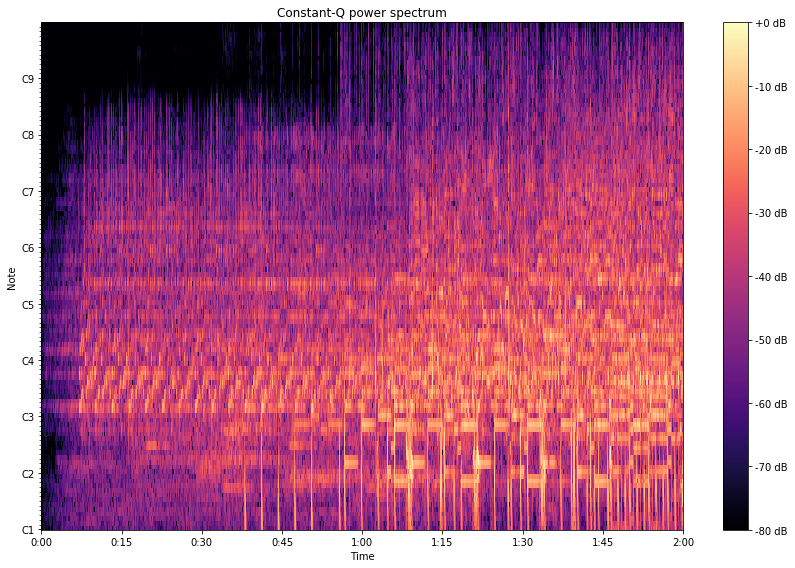

In [9]:
if not os.path.exists('D.npy'):
    plt.figure(figsize=(12, 8))
    display.specshow(librosa.amplitude_to_db(C, ref=np.max), sr=sr_resampled*2, x_axis='time', y_axis='cqt_note', bins_per_octave=bins_per_octave) 
    plt.title('Constant-Q power spectrum')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()

In [10]:
from __future__ import print_function

import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

from IPython.display import HTML

import torch_models

In [33]:
if is_changed(torch_models):
    torch_models = reload(torch_models)
    
# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [34]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Number of training epochs
num_epochs = 50

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [36]:
if not os.path.exists('dataset.npy'):
    stft_mean = D.mean(axis=1)
    stft_std = D.std(axis=1)
    D_stand = (((D.T - stft_mean)/stft_std).T).astype("double")
    D_test_stand = (((D_test.T - stft_mean)/stft_std).T).astype("double")

    cqt_mean = C.mean(axis=1)
    cqt_std = C.std(axis=1)
    C_stand = (((C.T - cqt_mean)/cqt_std).T).astype("double")
    C_test_stand = (((C_test.T - cqt_mean)/cqt_std).T).astype("double")

    np.save('D.npy', D_stand)
    np.save('Dt.npy', D_test_stand)
    np.save('C.npy', C_stand)
    np.save('Ct.npy', C_test_stand)
else:
    D_stand = np.load('D.npy')
    D_test_stand = np.load('Dt.npy')
    C_stand = np.load('C.npy')
    C_test_stand = np.load('Ct.npy')

# Create the dataset
dataset = torch_models.STFT_CQT_Dataset(D_stand, C_stand)

testset = torch_models.STFT_CQT_Dataset(D_test_stand, C_test_stand)    
    
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [37]:
# custom weights initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.kaiming_normal_(w, nonlinearity='relu')
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('Conv') != -1:
        nn.init.kaiming_normal_(w, nonlinearity='relu')

In [38]:
# Create the STFT2CQT
stft2cqt = torch_models.STFT2CQT(ngpu).double().to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    stft2cqt = nn.DataParallel(stft2cqt, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
stft2cqt.apply(weights_init)

# Print the model
print(stft2cqt)

STFT2CQT(
  (main): Sequential(
    (0): Linear(in_features=1025, out_features=2050, bias=True)
    (1): BatchNorm1d(2050, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Linear(in_features=2050, out_features=1025, bias=True)
    (4): BatchNorm1d(1025, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): Linear(in_features=1025, out_features=512, bias=True)
    (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): Linear(in_features=512, out_features=256, bias=True)
    (10): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): Linear(in_features=256, out_features=108, bias=True)
    (13): Tanh()
  )
)


In [39]:
# Create the CQT2STFT
cqt2stft = torch_models.CQT2STFT(ngpu).double().to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    cqt2stft = nn.DataParallel(cqt2stft, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
cqt2stft.apply(weights_init)

# Print the model
print(cqt2stft)

CQT2STFT(
  (conv1): Conv1d(1, 16, kernel_size=(13,), stride=(1,), padding=(6,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm1d(54, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace)
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn2): BatchNorm1d(27, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace)
  (conv3): Conv1d(1, 16, kernel_size=(9,), stride=(1,), dilation=(9,))
  (bn3): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU(inplace)
  (conv4): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn4): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU(inplace)
)


In [ ]:
# Create the CQT2STFT_conv
cqt2stft_conv = torch_models.CQT2STFT_conv(ngpu).double().to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    cqt2stft_conv = nn.DataParallel(cqt2stft_conv, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
cqt2stft_conv.apply(weights_init)

# Print the model
print(cqt2stft_conv)

In [40]:
# Initialize MSELoss function
mseLoss = nn.MSELoss()

# Setup Adam optimizer for both stft2cqt, cqt2stft and cqt2stft_conv
optimizer_stft2cqt = optim.Adam(stft2cqt.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_cqt2stft = optim.Adam(cqt2stft.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_cqt2stft_conv = optim.Adam(cqt2stft_conv.parameters(), lr=lr, betas=(beta1, 0.999))

In [41]:
# Train
train_losses = []
test_losses = []

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    errs = []
    test_errs = []
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        stft2cqt.zero_grad()
        # Format batch
        stft = data[0].to(device)
        cqt = data[1].to(device)
        # Forward pass
        output = stft2cqt(stft)
        # Calculate loss
        err = mseLoss(cqt, output)
        # Calculate gradients for D in backward pass
        err.backward()
        # Update D
        optimizer_stft2cqt.step()
        
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss: %.4f'
                  % (epoch, num_epochs, i, len(dataloader), err.item()))
            
        # Save Losses for plotting later
        errs.append(err.item())
        
    with torch.no_grad():
        for j, test in enumerate(testloader, 0):
            stft_test = test[0].to(device)
            cqt_test = test[1].to(device)
            output_test = stft2cqt(stft_test)
            err_test = mseLoss(cqt_test, output_test)
            test_errs.append(err_test.item())

    train_losses.append(np.mean(errs))
    test_losses.append(np.mean(test_errs))
    print("Mean train error: {} \nMean test error: {} \n".format(np.mean(errs), np.mean(test_errs)))

Starting Training Loop...
[0/50][0/969]	Loss: 1.0393
[0/50][50/969]	Loss: 0.6764
[0/50][100/969]	Loss: 0.5918
[0/50][150/969]	Loss: 0.5402
[0/50][200/969]	Loss: 0.5615
[0/50][250/969]	Loss: 0.5946
[0/50][300/969]	Loss: 0.5235
[0/50][350/969]	Loss: 0.5102
[0/50][400/969]	Loss: 0.4882
[0/50][450/969]	Loss: 0.4796
[0/50][500/969]	Loss: 0.6073
[0/50][550/969]	Loss: 0.5904
[0/50][600/969]	Loss: 0.5635
[0/50][650/969]	Loss: 0.4529
[0/50][700/969]	Loss: 0.4686
[0/50][750/969]	Loss: 0.5732
[0/50][800/969]	Loss: 0.6101
[0/50][850/969]	Loss: 0.4789
[0/50][900/969]	Loss: 0.5151
[0/50][950/969]	Loss: 0.4630
Mean train error: 0.5734685151260148 
Mean test error: 1.9576423668878957 

[1/50][0/969]	Loss: 0.5838
[1/50][50/969]	Loss: 0.5906
[1/50][100/969]	Loss: 0.7379
[1/50][150/969]	Loss: 0.5706
[1/50][200/969]	Loss: 0.4672
[1/50][250/969]	Loss: 0.4314
[1/50][300/969]	Loss: 0.4201
[1/50][350/969]	Loss: 0.3509
[1/50][400/969]	Loss: 0.5934
[1/50][450/969]	Loss: 0.4419
[1/50][500/969]	Loss: 0.4475
[1/50

[12/50][500/969]	Loss: 0.5280
[12/50][550/969]	Loss: 0.5710
[12/50][600/969]	Loss: 0.5953
[12/50][650/969]	Loss: 0.5342
[12/50][700/969]	Loss: 0.4303
[12/50][750/969]	Loss: 0.7174
[12/50][800/969]	Loss: 0.4391
[12/50][850/969]	Loss: 0.6848
[12/50][900/969]	Loss: 0.4574
[12/50][950/969]	Loss: 0.3707
Mean train error: 0.4479650911330932 
Mean test error: 1.9824864679446725 

[13/50][0/969]	Loss: 0.4690
[13/50][50/969]	Loss: 0.3195
[13/50][100/969]	Loss: 0.4427
[13/50][150/969]	Loss: 0.4205
[13/50][200/969]	Loss: 0.3630
[13/50][250/969]	Loss: 0.4708
[13/50][300/969]	Loss: 0.4539
[13/50][350/969]	Loss: 0.4380
[13/50][400/969]	Loss: 0.4078
[13/50][450/969]	Loss: 0.5018
[13/50][500/969]	Loss: 0.3791
[13/50][550/969]	Loss: 0.3491
[13/50][600/969]	Loss: 0.4328
[13/50][650/969]	Loss: 0.4968
[13/50][700/969]	Loss: 0.4151
[13/50][750/969]	Loss: 0.4495
[13/50][800/969]	Loss: 0.3892
[13/50][850/969]	Loss: 0.4771
[13/50][900/969]	Loss: 0.4536
[13/50][950/969]	Loss: 0.5083
Mean train error: 0.4461759

[24/50][700/969]	Loss: 0.3887
[24/50][750/969]	Loss: 0.5122
[24/50][800/969]	Loss: 0.4929
[24/50][850/969]	Loss: 0.4347
[24/50][900/969]	Loss: 0.4163
[24/50][950/969]	Loss: 0.3378
Mean train error: 0.43174559655741274 
Mean test error: 1.992003135383577 

[25/50][0/969]	Loss: 0.4697
[25/50][50/969]	Loss: 0.4512
[25/50][100/969]	Loss: 0.4531
[25/50][150/969]	Loss: 0.3089
[25/50][200/969]	Loss: 0.5730
[25/50][250/969]	Loss: 0.3529
[25/50][300/969]	Loss: 0.4344
[25/50][350/969]	Loss: 0.4028
[25/50][400/969]	Loss: 0.5408
[25/50][450/969]	Loss: 0.4467
[25/50][500/969]	Loss: 0.5423
[25/50][550/969]	Loss: 0.4317
[25/50][600/969]	Loss: 0.4314
[25/50][650/969]	Loss: 0.4663
[25/50][700/969]	Loss: 0.4543
[25/50][750/969]	Loss: 0.5017
[25/50][800/969]	Loss: 0.4508
[25/50][850/969]	Loss: 0.4918
[25/50][900/969]	Loss: 0.4838
[25/50][950/969]	Loss: 0.4085
Mean train error: 0.4309769228591514 
Mean test error: 1.9858507147743096 

[26/50][0/969]	Loss: 0.5823
[26/50][50/969]	Loss: 0.3753
[26/50][100/96

[36/50][900/969]	Loss: 0.3924
[36/50][950/969]	Loss: 0.3783
Mean train error: 0.4237978395241457 
Mean test error: 1.9891430746168308 

[37/50][0/969]	Loss: 0.4058
[37/50][50/969]	Loss: 0.4163
[37/50][100/969]	Loss: 0.3719
[37/50][150/969]	Loss: 0.5553
[37/50][200/969]	Loss: 0.3700
[37/50][250/969]	Loss: 0.3141
[37/50][300/969]	Loss: 0.4597
[37/50][350/969]	Loss: 0.5857
[37/50][400/969]	Loss: 0.4301
[37/50][450/969]	Loss: 0.3952
[37/50][500/969]	Loss: 0.5264
[37/50][550/969]	Loss: 0.2996
[37/50][600/969]	Loss: 0.4365
[37/50][650/969]	Loss: 0.5535
[37/50][700/969]	Loss: 0.4154
[37/50][750/969]	Loss: 0.4504
[37/50][800/969]	Loss: 0.4406
[37/50][850/969]	Loss: 0.3992
[37/50][900/969]	Loss: 0.3614
[37/50][950/969]	Loss: 0.4488
Mean train error: 0.4231808730263263 
Mean test error: 1.988672869523201 

[38/50][0/969]	Loss: 0.3524
[38/50][50/969]	Loss: 0.3546
[38/50][100/969]	Loss: 0.3824
[38/50][150/969]	Loss: 0.4420
[38/50][200/969]	Loss: 0.4164
[38/50][250/969]	Loss: 0.4213
[38/50][300/969

[49/50][0/969]	Loss: 0.3846
[49/50][50/969]	Loss: 0.3389
[49/50][100/969]	Loss: 0.3600
[49/50][150/969]	Loss: 0.4399
[49/50][200/969]	Loss: 0.4423
[49/50][250/969]	Loss: 0.3947
[49/50][300/969]	Loss: 0.4246
[49/50][350/969]	Loss: 0.3274
[49/50][400/969]	Loss: 0.4182
[49/50][450/969]	Loss: 0.3441
[49/50][500/969]	Loss: 0.3902
[49/50][550/969]	Loss: 0.4661
[49/50][600/969]	Loss: 0.3105
[49/50][650/969]	Loss: 0.4128
[49/50][700/969]	Loss: 0.3277
[49/50][750/969]	Loss: 0.4984
[49/50][800/969]	Loss: 0.4645
[49/50][850/969]	Loss: 0.4028
[49/50][900/969]	Loss: 0.2897
[49/50][950/969]	Loss: 0.4909
Mean train error: 0.4191665787457057 
Mean test error: 1.981270118194612 



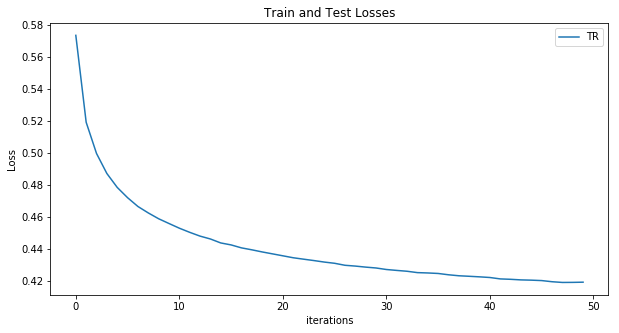

In [42]:
# Results
plt.figure(figsize=(10,5))
plt.title("Train Loss")
plt.plot(train_losses,label="TR")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

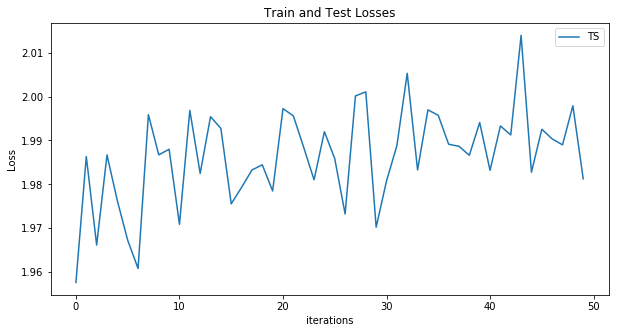

In [43]:
# Results
plt.figure(figsize=(10,5))
plt.title("Test Loss")
plt.plot(test_losses,label="TS")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()